In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.dataset_utils import load_data, preprocess
from feature_extraction import extract_features

In [2]:
df = load_data(filtered=True)
preprocessed_df = preprocess(df)

In [ ]:
features = extract_features(preprocessed_df[preprocessed_df['class_id'].isin([0, 4])])

In [ ]:
def prepare_data(features):
    class_0_features = features[features['class'] == 0].iloc[:, :-2]
    means = class_0_features.mean()
    stds = class_0_features.std()
    # replace missing values with the mean of class 0
    features.iloc[:, :-2] = features.iloc[:, :-2].fillna(means)
    # standardize features
    features.iloc[:, :-2] = ((features.iloc[:, :-2] - means) / stds)
    # randomly shuffle the rows
    features[:] = features.sample(frac=1, random_state=42).reset_index(drop=True)


In [51]:
prepare_data(features)

with open('features.csv', 'w') as f:
    features.to_csv(f, index=False)

In [2]:
features = pd.read_csv('features.csv')

In [ ]:
def plot_distributions(df):
    df_filtered = df[df['class'].isin([0, 4])]
    
    columns = df.columns[:-2]
    num_cols = 4
    num_rows = (len(columns) + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axes = axes.flatten()
    
    # Iterate over each column and plot the KDE
    for i, col in enumerate(columns):
        if col.startswith('eda'):
            bg_color = (0.68, 0.85, 0.90, 0.2)
        elif col.startswith('ecg'):
            bg_color = (1.0, 0.71, 0.76, 0.2)
        else:
            bg_color = (0.68, 1.0, 0.68, 0.2)
        
        axes[i].set_facecolor(bg_color)
        
        sns.kdeplot(data=df_filtered[df_filtered['class'] == 0], x=col, ax=axes[i], label='Class 0', linewidth=2)
        sns.kdeplot(data=df_filtered[df_filtered['class'] == 4], x=col, ax=axes[i], label='Class 4', linewidth=2)
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))
        axes[i].yaxis.set_major_locator(plt.MaxNLocator(4))
        axes[i].set_ylabel('Density', fontsize=12)
        axes[i].legend()
    
    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

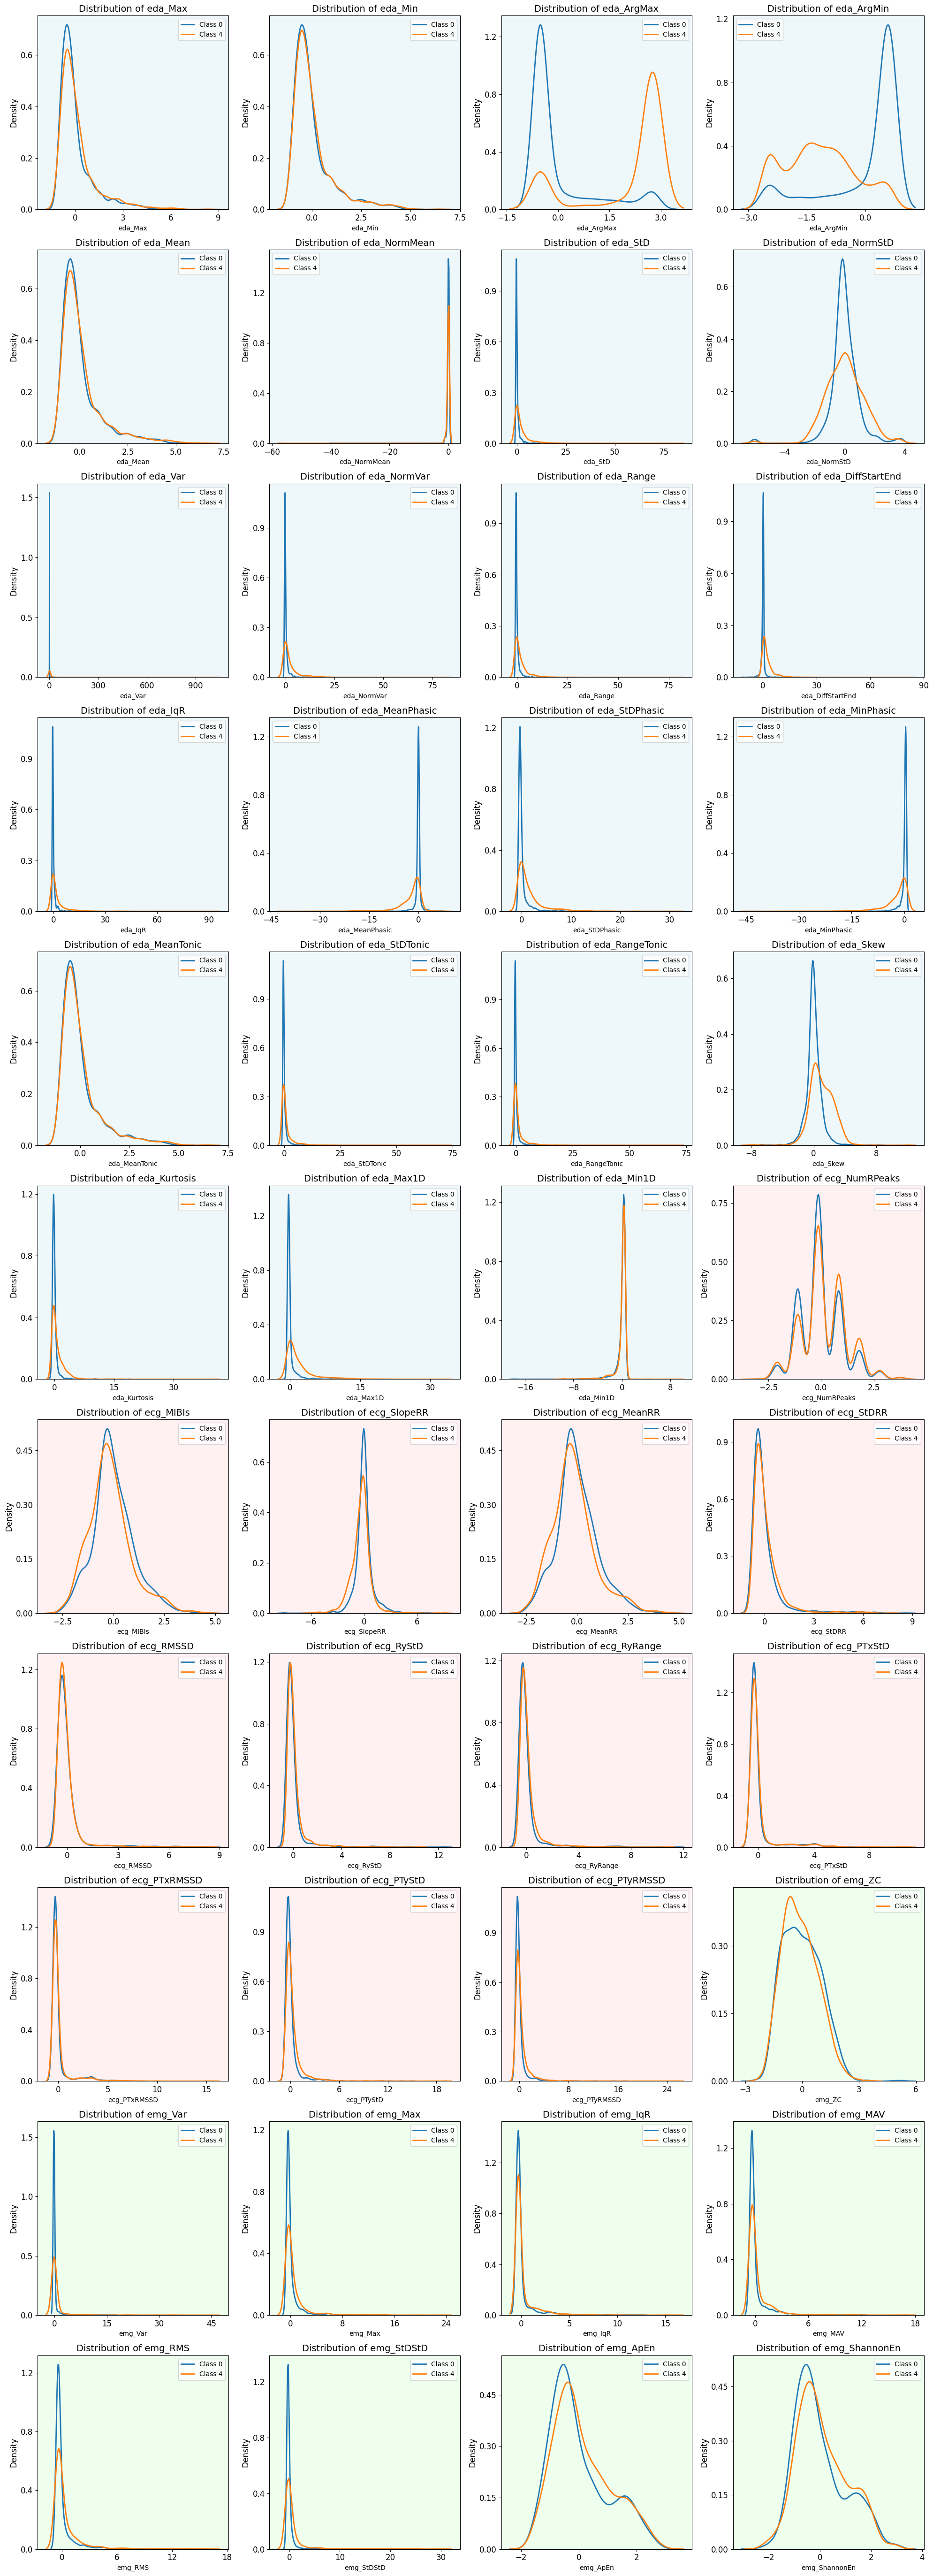

In [ ]:
plot_distributions(features)

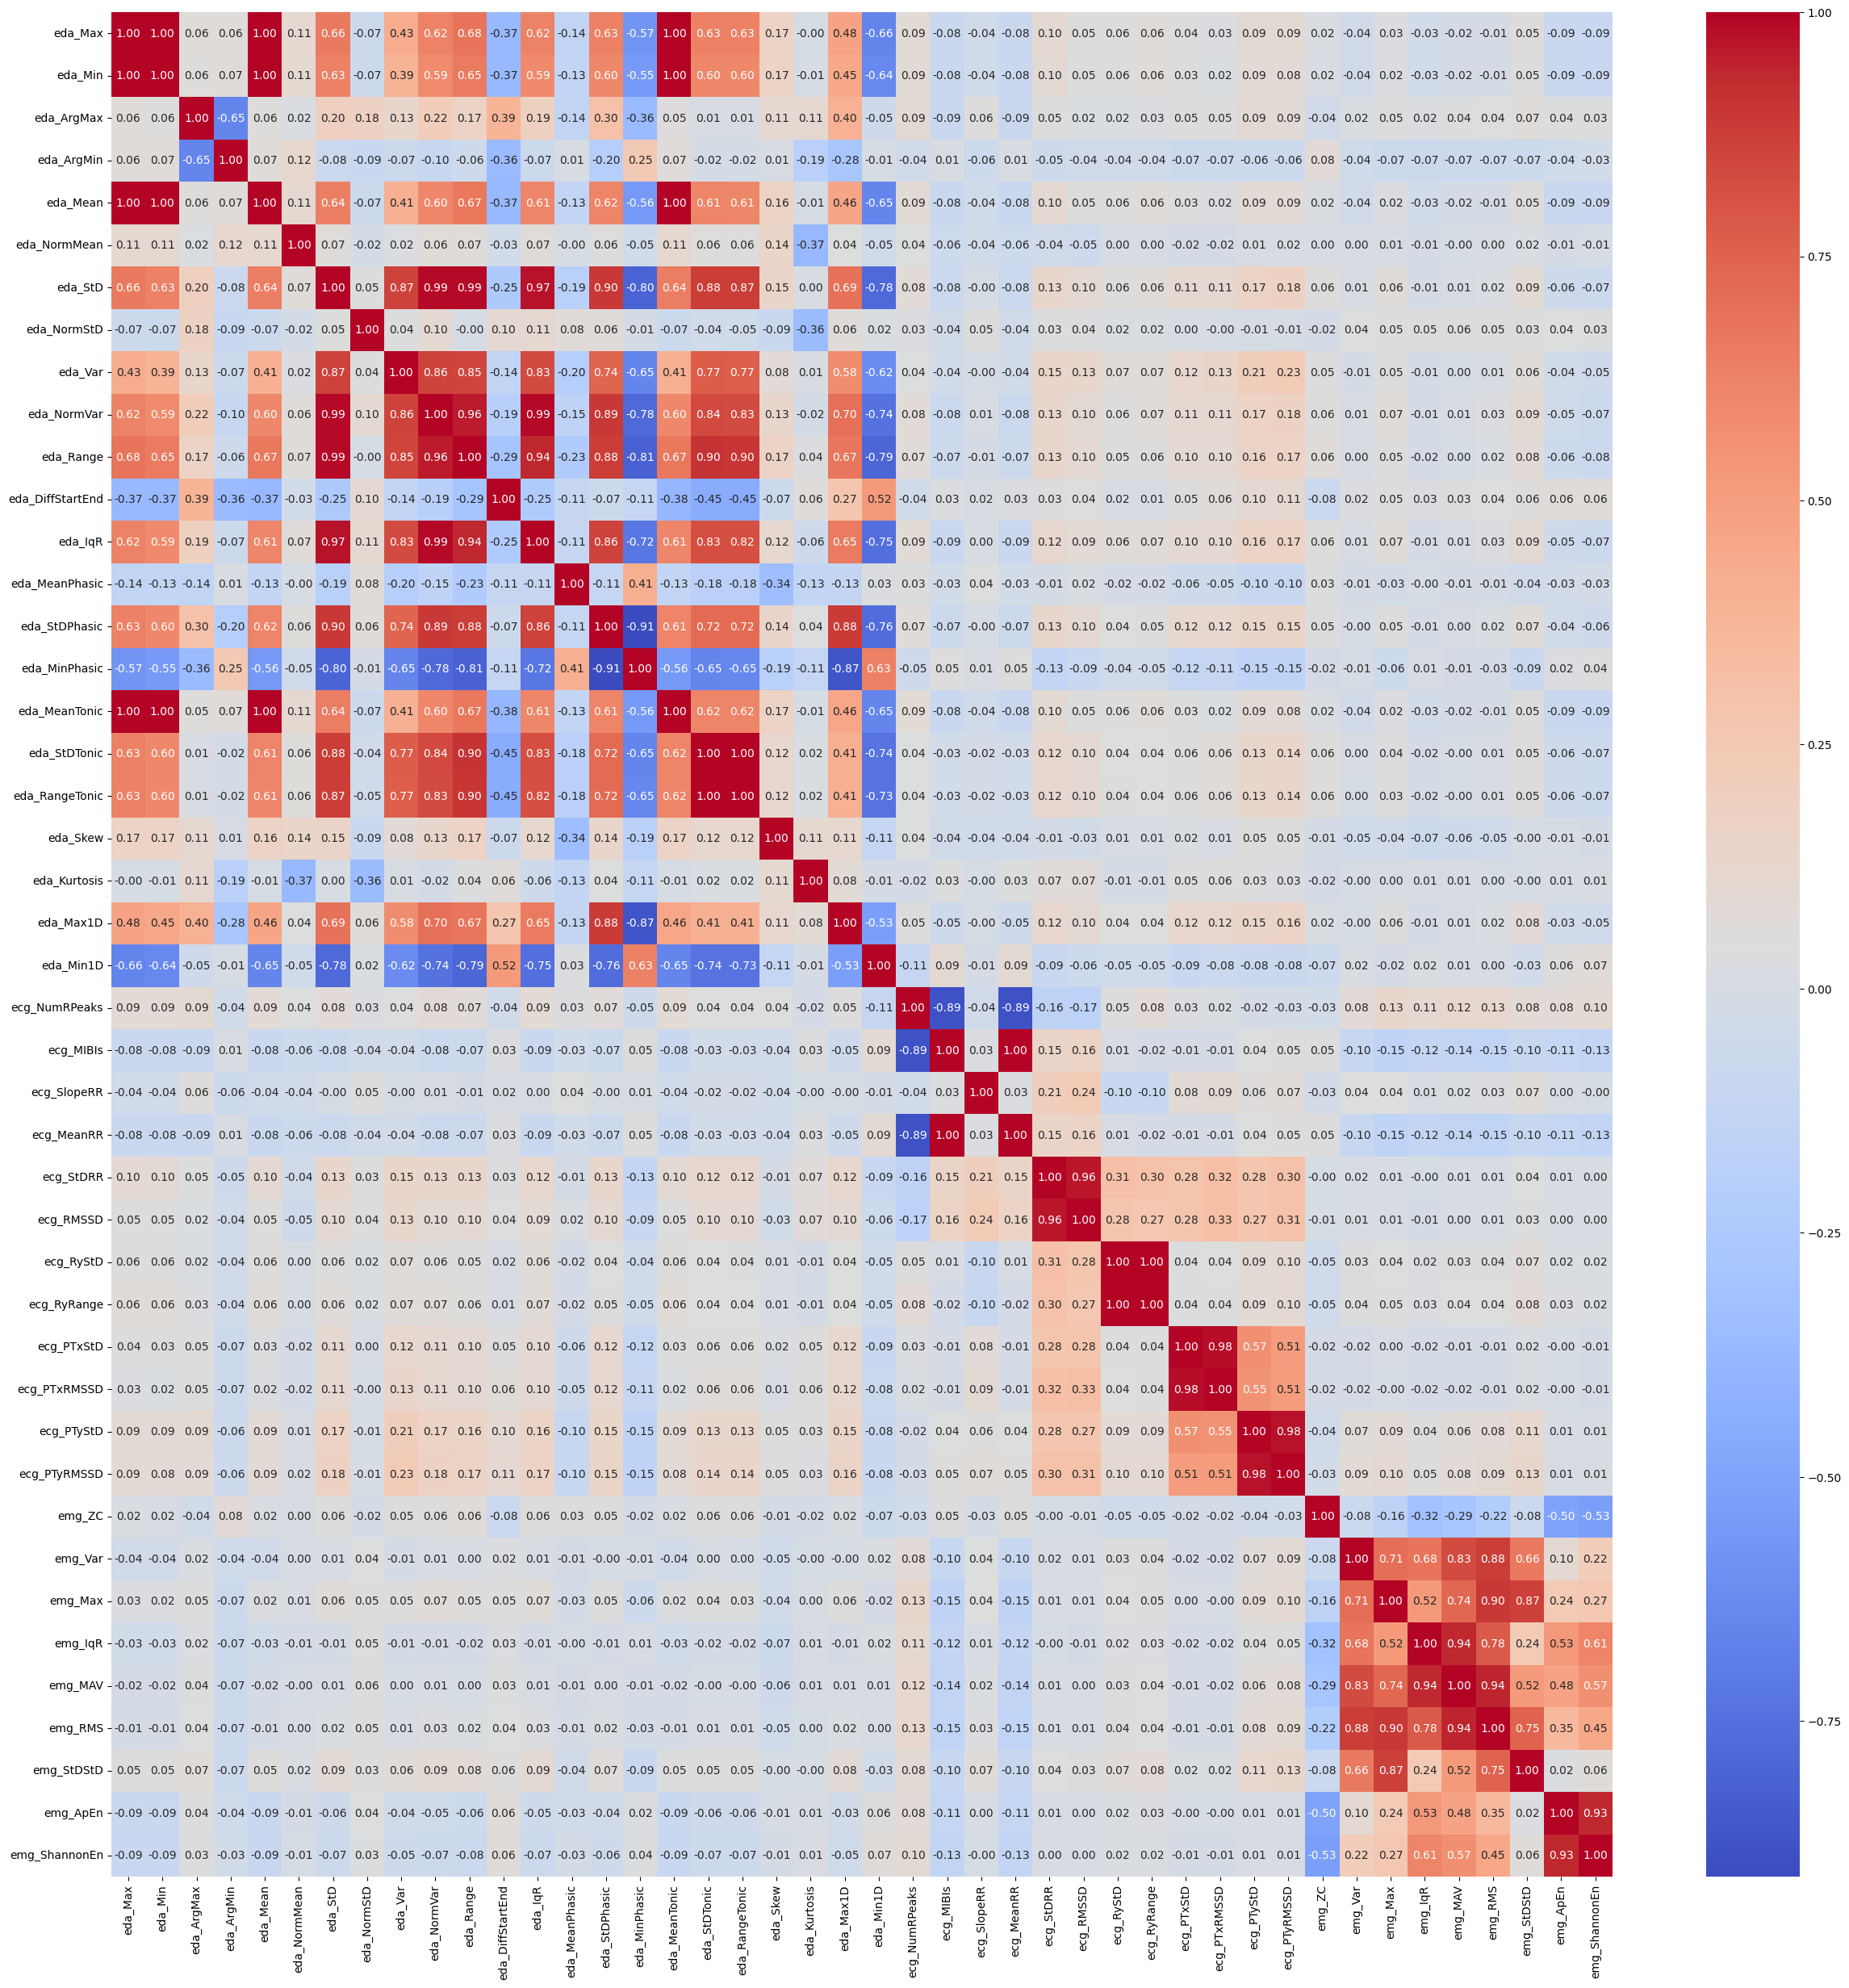

In [ ]:
# correlation matrix
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(features[features['class'] == 0].iloc[:, :-2].corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
plt.show()

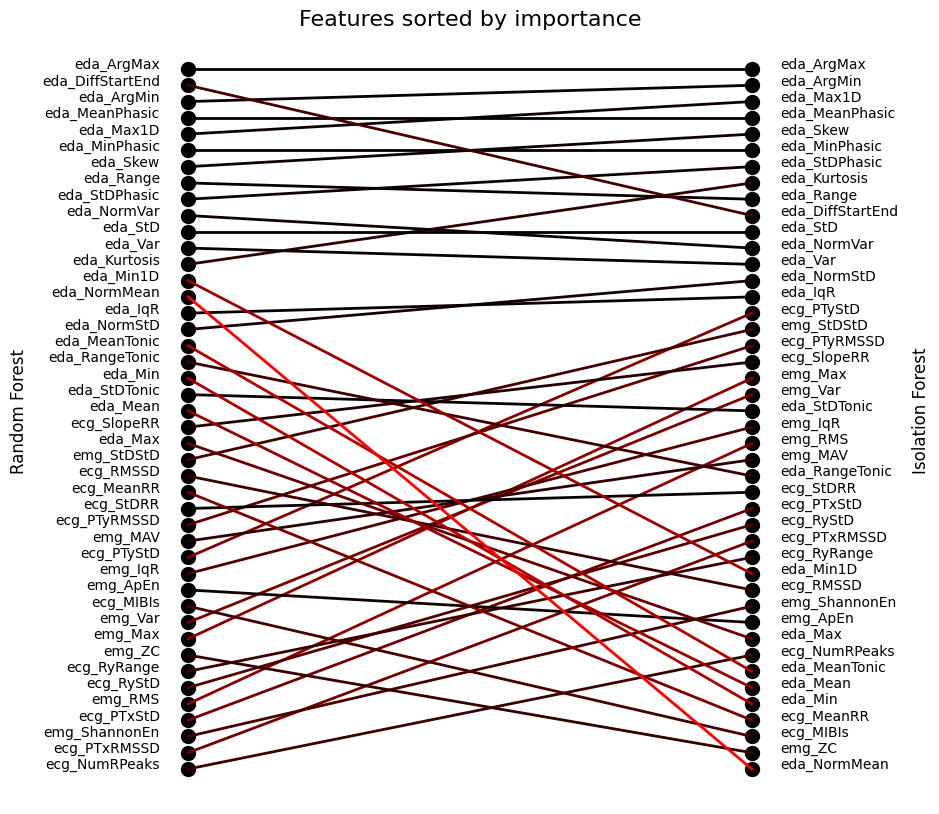

In [17]:
feature_importance_rf = ['eda_ArgMax', 'eda_DiffStartEnd', 'eda_ArgMin', 'eda_MeanPhasic', 'eda_Max1D', 'eda_MinPhasic', 'eda_Skew', 'eda_Range', 'eda_StDPhasic', 'eda_NormVar', 'eda_StD', 'eda_Var', 'eda_Kurtosis', 'eda_Min1D', 'eda_NormMean', 'eda_IqR', 'eda_NormStD', 'eda_MeanTonic', 'eda_RangeTonic', 'eda_Min', 'eda_StDTonic', 'eda_Mean', 'ecg_SlopeRR', 'eda_Max', 'emg_StDStD', 'ecg_RMSSD', 'ecg_MeanRR', 'ecg_StDRR', 'ecg_PTyRMSSD', 'emg_MAV', 'ecg_PTyStD', 'emg_IqR', 'emg_ApEn', 'ecg_MIBIs', 'emg_Var', 'emg_Max', 'emg_ZC', 'ecg_RyRange', 'ecg_RyStD', 'emg_RMS', 'ecg_PTxStD', 'emg_ShannonEn', 'ecg_PTxRMSSD', 'ecg_NumRPeaks']

feature_importance_if = ['eda_ArgMax', 'eda_ArgMin', 'eda_Max1D', 'eda_MeanPhasic', 'eda_Skew', 'eda_MinPhasic', 'eda_StDPhasic', 'eda_Kurtosis', 'eda_Range', 'eda_DiffStartEnd', 'eda_StD', 'eda_NormVar', 'eda_Var', 'eda_NormStD', 'eda_IqR', 'ecg_PTyStD', 'emg_StDStD', 'ecg_PTyRMSSD', 'ecg_SlopeRR', 'emg_Max', 'emg_Var', 'eda_StDTonic', 'emg_IqR', 'emg_RMS', 'emg_MAV', 'eda_RangeTonic', 'ecg_StDRR', 'ecg_PTxStD', 'ecg_RyStD', 'ecg_PTxRMSSD', 'ecg_RyRange', 'eda_Min1D', 'ecg_RMSSD', 'emg_ShannonEn', 'emg_ApEn', 'eda_Max', 'ecg_NumRPeaks', 'eda_MeanTonic', 'eda_Mean', 'eda_Min', 'ecg_MeanRR', 'ecg_MIBIs', 'emg_ZC', 'eda_NormMean']

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_sorted_list_difference(array1, array2):
    array1.reverse()
    array2.reverse()
    index_map = {item: (array1.index(item), array2.index(item)) for item in array1 if item in array2}
    steepness = [abs(idx1 - idx2) for idx1, idx2 in index_map.values()]
    norm = mcolors.Normalize(vmin=min(steepness), vmax=max(steepness))
    custom_cmap = LinearSegmentedColormap.from_list("black_red", ["black", "red"])
    
    fig, ax = plt.subplots(figsize=(8, 10))
    x1, x2 = [0] * len(array1), [1] * len(array2)
    y1, y2 = list(range(len(array1))), list(range(len(array2)))
    
    ax.scatter(x1, y1, color='black', s=100)
    ax.scatter(x2, y2, color='black', s=100)
    
    for i, label in enumerate(array1):
        if label in index_map:
            idx1, idx2 = index_map[label]
            ax.text(x1[i] - 0.05, idx1, label, ha='right', color='black')
            ax.text(x2[i] + 0.05, idx2, label, ha='left', color='black')
    
    for label, (idx1, idx2) in index_map.items():
        line_color = custom_cmap(norm(abs(idx1 - idx2)))
        ax.plot([0, 1], [idx1, idx2], color=line_color, linewidth=2)
    
    ax.axis('off')
    ax.set_title("Features sorted by importance", fontsize=16)
    
    # Add labels to the left and right axes
    ax.text(-0.3, len(array1) / 2, 'Random Forest', va='center', ha='center', rotation='vertical', fontsize=12, color='black')
    ax.text(1.3, len(array2) / 2, 'Isolation Forest', va='center', ha='center', rotation='vertical', fontsize=12, color='black')
    
    plt.show()

plot_sorted_list_difference(feature_importance_rf, feature_importance_if)